In [4]:
import numpy as np
import os 
from pathlib import Path
from typing import List, Dict, Union
import glob
from matplotlib.patches import Polygon

PathLike = Union[Path, str]
import json
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from dataset import get_paths, PathLike, is_image
from pycocotools.coco import COCO
import pandas as pd
import json
from dataset.preprossesing import resize_images
from PIL import Image

In [27]:
# resize_images(['../../dataset/49/images/'], ['bmp'],'../../dataset/49/images_resize/', (1024,1024),{'dtype': float})

In [28]:
test_image = list(filter( lambda x: True if is_image(x) else False, get_paths('../../dataset/49/images_resize/')))
for f in test_image:
    print(f)
    image = Image.open(f)
    image = image.convert('RGB')
    image.save(f.replace('bmp','jpg'))

../../dataset/49/images_resize/5,54-0.0-637370541659123645.bmp
../../dataset/49/images_resize/5,85-0.0-637370548123887553.bmp
../../dataset/49/images_resize/3,07-0.0-637370559477198705.bmp
../../dataset/49/images_resize/9,62-0.0-637370592850767671.bmp
../../dataset/49/images_resize/9,7-0.0-637370544772717412.bmp
../../dataset/49/images_resize/7,77-0.0-637370588692437344.bmp
../../dataset/49/images_resize/11,87-0.0-637370593741332591.bmp
../../dataset/49/images_resize/9,7-0.0-637370544028720714.bmp
../../dataset/49/images_resize/5,7-0.0-637370540913186119.bmp
../../dataset/49/images_resize/4,03-0.0-637370562047395842.bmp
../../dataset/49/images_resize/10,41-0.0-637370590582944499.bmp
../../dataset/49/images_resize/5,56-0.0-637370564420769934.bmp
../../dataset/49/images_resize/4,88-0.0-637370560619835222.bmp
../../dataset/49/images_resize/7,24-0.0-637370586812328433.bmp
../../dataset/49/images_resize/6,34-0.0-637370563044736179.bmp
../../dataset/49/images_resize/10,4-0.0-6373705901578146

In [ ]:
list_path_to_annotations = list(filter( lambda x: True if x.split('.')[-1] == 'json' else False, get_paths('../../dataset/annotation/')))
list_path_to_annotations = list(filter( lambda x: True if x.split('.')[-1] == 'json' else False, get_paths('../../dataset/all_data/all_data_54/annotations/')))
len(list_path_to_annotations)
list_path_to_annotations

In [4]:
coco = COCO(list_path_to_annotations[0])
print(len(coco.anns), len(coco.imgs))
image_names = coco.imgs

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
11175 221


In [5]:
frame = pd.DataFrame({d['id']: d for d in json.load(open(list_path_to_annotations[0],'r'))['annotations']}).T
frame

,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes
1,1,1,1,"[[1764.35, 458.91, 1796.0, 467.07, 1815.39, 47...",5651.0,"[1734.75, 458.91, 98.0, 83.71]",0,{'occluded': False}
2,2,1,1,"[[921.77, 1153.82, 920.24, 1125.23, 868.69, 11...",13644.0,"[729.34, 1092.05, 192.43, 125.06]",0,{'occluded': False}
3,3,1,1,"[[1906.64, 58.69, 1929.38, 103.0, 1921.22, 120...",4833.0,"[1833.77, 58.69, 95.61, 67.63]",0,{'occluded': False}
4,4,1,1,"[[123.77, 1018.74, 130.08, 998.91, 137.29, 987...",23652.0,"[0.0, 820.46, 153.51, 198.28]",0,{'occluded': False}
5,5,1,1,"[[101.79, 1846.46, 93.18, 1818.71, 110.41, 178...",21677.0,"[93.18, 1660.8, 218.2, 192.36]",0,{'occluded': False}
...,...,...,...,...,...,...,...,...
11171,11171,221,1,"[[1284.4, 413.81, 1299.12, 406.88, 1307.78, 38...",8718.0,"[1284.4, 366.18, 140.29, 88.33]",0,{'occluded': False}
11172,11172,221,1,"[[889.51, 1892.07, 851.4, 1909.39, 820.23, 189...",12612.0,"[759.61, 1800.28, 158.47, 109.11]",0,{'occluded': False}
11173,11173,221,1,"[[2168.4, 984.9, 2164.7, 980.78, 2146.57, 968....",4149.0,"[2088.06, 958.94, 121.13, 63.45]",0,{'occluded': False}
11174,11174,221,1,"[[443.17, 929.52, 445.01, 973.74, 485.54, 992....",33166.0,"[443.17, 850.31, 263.44, 175.01]",0,{'occluded': False}


In [8]:
from typing import List, Union

def image_segmentation_from_frame(frame: pd.DataFrame, img_id: int, category_id:int, images):
    maska = (frame.image_id == img_id) & (frame.category_id == category_id)
    h_img = images[img_id]['height']
    w_img = images[img_id]['width']
    return [{category_id: normalize_segment(np.array(list(s[0])), h_img, w_img)} for s in frame[maska].segmentation]

def normalize_segment(segment, h_img, w_img):
    segment[::2] /=w_img
    segment[1::2]/=h_img
    return segment

            
img_id = 13
s = image_segmentation_from_frame(frame, img_id, 1, image_names)
# save_segmentation(s,image_names[img_id]['file_name'].split('.')[-2] + '.txt')

In [9]:
out_path = Path('/home/kirilman/Project/dataset/all_data/segmentation/')

In [13]:
for k, v in image_names.items():
    if isinstance(v, dict):
        img_id = v['id']
        segments = image_segmentation_from_frame(frame, img_id, 1,image_names)
        filename = str(out_path) + v['file_name'].split('.')[-2] + '.txt'
        save_segmentation(segments, filename)

NameError: name 'save_segmentation' is not defined

In [ ]:
arr_segment = np.array(segments[0][1])
arr_segment[::2] = arr_segment[::2]/

In [ ]:
count_images = 0
for path_2_anno in list_path_to_annotations:
    coco = COCO(path_2_anno)
    count_images+=len(coco.imgs)
    print(len(coco.anns), len(coco.imgs))
    image_names = coco.imgs
    for k, image in image_names.items():
        if isinstance(image, dict):
            img_id = image['id']
            segments = image_segmentation_from_frame(frame, img_id, 1,image_names)
            filename = str(out_path / image['file_name'].split('/')[-1].split('.')[-2]) + '.txt'
            # save_segmentation(segments, filename)
            print(path_2_anno + image['file_name'])

In [3]:
sys.path.append('/home/kirilman/Project/asbestos/dataset')
from dataset import is_image
from dataset.processor import JsonSegmentProcessing
import shutil

In [343]:
!rm -r /home/kirilman/Project/dataset/segmentation/seg/*.txt

In [4]:
list_path_to_annotations
proccesor = JsonSegmentProcessing(list_path_to_annotations[0], 1, '/home/kirilman/Project/dataset/all_data/segmentation/')
proccesor.process() 

[{1: array([0.9529591 , 0.66669434, 0.9549537 , 0.65027832, 0.95994213,
         0.63386719, 0.97390818, 0.61619141, 0.97989583, 0.61366211,
         0.98587963, 0.61366211, 0.99186728, 0.63386719, 0.99984568,
         0.63134277, 1.        , 0.63765625, 0.99485725, 0.65785645,
         0.97790123, 0.66669434, 0.96293596, 0.67300781])},
 {1: array([0.49762731, 0.743125  , 0.49854938, 0.75107422, 0.50224537,
         0.75995605, 0.51314429, 0.75902344, 0.5242284 , 0.75832031,
         0.53087577, 0.75715332, 0.53309414, 0.75294434, 0.53346451,
         0.73564453, 0.53346451, 0.72512207, 0.53253858, 0.71811035,
         0.52958333, 0.71039551, 0.5242284 , 0.70478516, 0.51018904,
         0.69589844, 0.50427855, 0.69145996, 0.50113812, 0.68958984,
         0.49559414, 0.68935547, 0.4943017 , 0.69145996, 0.4943017 ,
         0.69449707, 0.49910494, 0.69730469, 0.50076775, 0.70992676,
         0.50113812, 0.72208496, 0.49947531, 0.7309668 , 0.49689043,
         0.74382812])},
 {1: array([0

In [345]:
s = 0
unused = ['../../dataset/annotation/open-pit-zoomed-161120/instances_default.json', '../../dataset/annotation/pits_stones_detections_161220/instances_default.json']
for p in list_path_to_annotations:
    if p in unused:
        print(p)
        continue
    proccesor = JsonSegmentProcessing(p, 1, '/home/kirilman/Project/dataset/segmentation/seg/')
    proccesor.process() 

../../dataset/annotation/open-pit-zoomed-161120/instances_default.json
../../dataset/annotation/pits_stones_detections_161220/instances_default.json


In [30]:
print('Количество меток:', 
len(list(filter( lambda x: True if x.split('.')[-1] == 'txt' else False, os.listdir('/home/kirilman/Project/dataset/segmentation/seg/')))) )

Количество меток: 394


In [363]:
print(unused)
for p in unused:
    proccesor = JsonSegmentProcessing(p,
                                  1, '/home/kirilman/Project/dataset/segmentation/test/')
    proccesor.process()

['../../dataset/annotation/open-pit-zoomed-161120/instances_default.json', '../../dataset/annotation/pits_stones_detections_161220/instances_default.json']


In [361]:
image_files = list(filter( lambda x: True if x.split('.')[-1] != 'txt' else False, get_paths('../../dataset/segmentation/seg/')))
label_files = list(filter( lambda x: True if x.split('.')[-1] == 'txt' else False, get_paths('../../dataset/segmentation/seg/')))
images = {}
for image_file in image_files:
    for label in label_files:
        if image_file.split('.')[-2] in label:
            images[label] = image_file
len(images)

350

In [362]:
root_path = Path('/home/kirilman/Project/dataset/segmentation/')
count = len(label_files)
print(count, count*0.1)
val_index = np.random.choice(label_files,35)

for f_label, f_image in images.items():
    if f_label in val_index:
        shutil.copy(f_label, root_path / 'val' / Path(f_label).name)
        shutil.copy(f_image, root_path / 'val' / Path(f_image).name)
    else:
        shutil.copy(f_label, root_path / 'train' / Path(f_label).name)
        shutil.copy(f_image, root_path / 'train' / Path(f_image).name)

350 35.0


In [ ]:
for root in unused:
    for f in os.listdir(Path(root).parent):
        save_path = Path('/home/kirilman/Project/dataset/segmentation/test') / f.name
        shutil.copy(Path(root) + Path(f).name, save_path)

In [383]:
unused

['../../dataset/annotation/open-pit-zoomed-161120/instances_default.json',
 '../../dataset/annotation/pits_stones_detections_161220/instances_default.json']

In [7]:
from dataset.preprossesing import resize_images
import cv2

### Merge annotation from train and prediction-segment

In [325]:
train_files = list(filter( lambda x: True if x.split('.')[-1] == 'txt' else False, get_paths('../../dataset/segmentation/merge/train/')))
predict_file = list(filter( lambda x: True if x.split('.')[-1] == 'txt' else False, get_paths('../yolov5/runs/predict-seg/exp4/labels')))
print(len(train_files), len(predict_file))

318 318


In [286]:
train_files = list(filter( lambda x: True if x.split('.')[-1] == 'txt' else False, get_paths('../../dataset/segmentation/merge/val/')))
predict_file = list(filter( lambda x: True if x.split('.')[-1] == 'txt' else False, get_paths('../yolov5/runs/predict-seg/exp5/')))
print(len(train_files), len(predict_file))

32 32


In [326]:
labels = []
for train, pred in zip(train_files, predict_file):
    # print(train, pred)
    with open(train, 'a') as f_train:
        with open(pred, 'r') as f_pred:
            labels = f_pred.readlines()
            for label in labels:
                arr_label = np.fromstring(label, sep = ' ')
                arr_label[1:] = arr_label[1:]/1024
        
                f_train.write(to_string(arr_label))
                            

1


(0.0, 1.0)

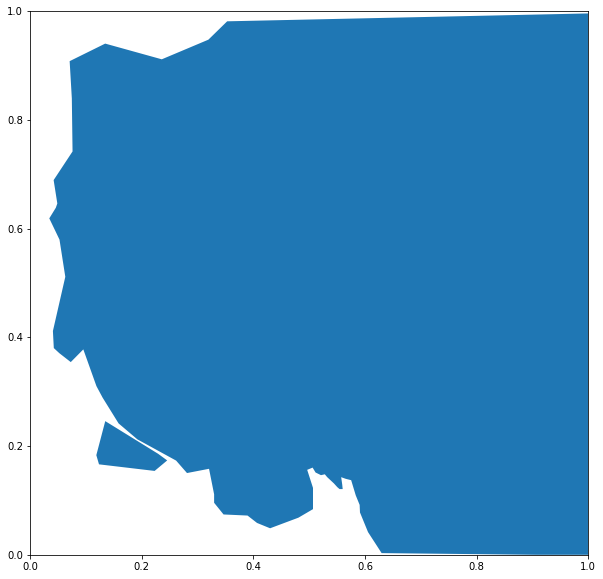

In [20]:
with open('../../dataset/all_data/segmentation/136.txt', 'r') as f:
    labels = f.readlines()
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

# polygon1 = Polygon([(0,1), (1,1), (3,0),])

fig, ax = plt.subplots(1,1, figsize = (10,10))
for i,label in enumerate(labels):
    label = np.fromstring(label, sep=' ')[1:]
    polygon1 = Polygon([(x,y) for x,y in zip(label[0::2],label[1::2])])
    polygon1
    ax.add_patch(polygon1)
print(i)   
plt.ylim(0,1)
plt.xlim(0,1)

(0.0, 1.0)

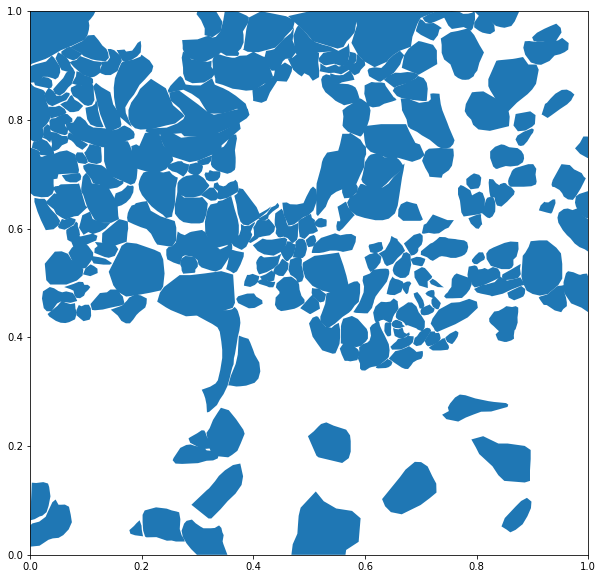

In [19]:
with open('../yolov5/runs/predict-seg/exp4/labels/637412006957367334.txt', 'r') as f:
    labels = f.readlines()

with open('/home/kirilman/Project/dataset/segmentation/small/train/ManualGeneralImage_13_56_14.txt', 'r') as f:
    labels = f.readlines()
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

# polygon1 = Polygon([(0,1), (1,1), (3,0),])

fig, ax = plt.subplots(1,1, figsize = (10,10))
for i,label in enumerate(labels):
    label = np.fromstring(label, sep=' ')[1:]
    polygon1 = Polygon([(x,y) for x,y in zip(label[0::2],label[1::2])])
    area = sPolygon([(x,y) for x,y in zip(label[0::2],label[1::2])]).area
    ax.add_patch(polygon1)

    # if area > 0.005:
        # ax.add_patch(polygon1)
    # if area > 0.00:
    #     ax.add_patch(polygon1)  
plt.ylim(0,1)
plt.xlim(0,1)
# labels

### Segmentation filter, squre analyse

In [6]:
from shapely.geometry import Polygon as sPolygon
from dataset.path_utils import get_paths_from_dirs
from dataset.processor import SegmentSquareFilter
# !pip install shapely
sPolygon([(0,0),(2,0),(1,1), (0,2)]).area

2.0

9487 0.01745830167228839 0.004327205
8678


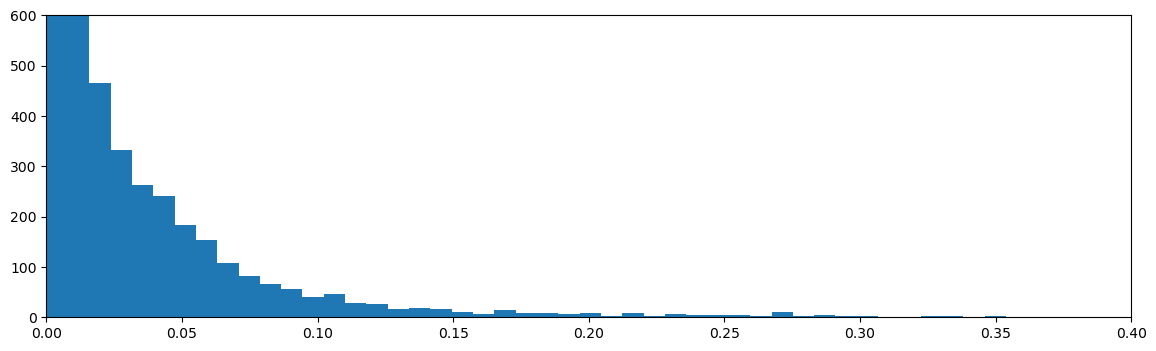

In [15]:
def read_segmentation_labels(p: PathLike):
    with open(p, 'r') as f:
        lines = f.readlines()
        return [np.fromstring(line, sep=' ') for line in lines]

files = get_paths_from_dirs(['../../dataset/segmentation/train/'], ['txt'])
areas = []

for f in files:
    labels = read_segmentation_labels(f)
    for label in labels:
        mask = label[1:]
        p = sPolygon([(x,y) for x,y in zip(mask[0::2], mask[1::2])] )
        areas+=[p.area]
areas = np.array(areas)

print(len(areas), areas.mean(), np.median(areas))
fig = plt.figure(figsize=(14,4),dpi = 100)
plt.hist(areas,60);
plt.ylim(0,600)
plt.xlim(0.00,0.4)
print(len(np.where(areas>0.001)[0]))

In [16]:
files = get_paths_from_dirs(['../../dataset/segmentation/train/'], ['txt'])
for f in files:
    seg = SegmentSquareFilter(f, '../../dataset/segmentation/labels/large_segment/train/', 0.005)
    seg.process()

In [31]:
files = get_paths_from_dirs(['../../dataset/segmentation/val/'], ['txt'])
for f in files:
    seg = SegmentSquareFilter(f, '../../dataset/segmentation/labels/large_segment/val/', 0.005)
    seg.process()

In [6]:
files = get_paths_from_dirs(['../../dataset/segmentation/test/'], ['txt'])
for f in files:
    seg = SegmentSquareFilter(f, '../../dataset/segmentation/labels/large_segment/test', 0.005, True)
    seg.process()

In [32]:
## small object

In [16]:
files = get_paths_from_dirs(['../../dataset/segmentation/train/'], ['txt'])
for f in files:
    seg = SegmentSquareFilter(f, '../../dataset/segmentation/labels/small/train/', 0.01, False)
    seg.process()

In [17]:
files = get_paths_from_dirs(['../../dataset/segmentation/val/'], ['txt'])
for f in files:
    seg = SegmentSquareFilter(f, '../../dataset/segmentation/labels/small/val/', 0.01, False)
    seg.process()

In [7]:
files = get_paths_from_dirs(['../../dataset/segmentation/test/'], ['txt'])
for f in files:
    seg = SegmentSquareFilter(f, '../../dataset/segmentation/labels/small/test/', 0.01, False)
    seg.process()

#### Merge annotations

In [11]:
root = os.getcwd()
root = Path(root.split('asbestos')[0])
list_path_to_annotations = list(filter( lambda x: True if x.split('.')[-1] == 'json' else False, get_paths(root / ')
# list_path_to_annotations = list(filter( lambda x: True if x.split('.')[-1] == 'json' else False, get_paths('../../dataset/all_data/all_data_54/annotations/')))
# len(list_path_to_annotations)
# list_path_to_annotations

In [ ]:
!ls ../../../da